<a href="https://colab.research.google.com/github/diro5t/deep_quadric_learning/blob/main/TorchQuadMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(C) Dirk Roeckmann 2023

Simple PyTorch MNIST ~25K parameter model classifier with quadric layers: 784-16-10, batch size of 128 and 20 epochs.

NOTE: The goal is NOT to find the minimum model or a certain target accuracy, but to compare it with a ~100K linear model which achieves comparable accuracy after the same number of epochs (see TorchLinMNIST.ipynb).

More about quadric models here:

https://github.com/diro5t/deep_quadric_learning

This paradigm is based on my research here:

https://scholar.google.com/citations?hl=en&user=hamuGh4AAAAJ

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
from torch.nn.parameter import Parameter, UninitializedParameter

import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
transf = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),])

In [ ]:
batch_size = 128

train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transf)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transf)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
img_iter = iter(train_loader)
images, labels = next(img_iter)

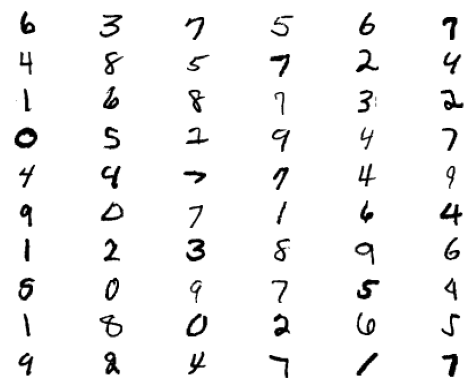

In [ ]:
figure = plt.figure()
img_num = 60
for index in range(1, img_num + 1):
    plt.subplot(10, 6, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Custom Quadric PyTorch Layer
class Quadric(nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    qweight: Tensor
    lweight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # quadratic weights
        self.qweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # linear weights
        self.lweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # bias
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.qweight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.lweight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in_q, _ = nn.init._calculate_fan_in_and_fan_out(self.qweight)
            fan_in_l, _ = nn.init._calculate_fan_in_and_fan_out(self.lweight)
            bound = 1 / math.sqrt(fan_in_l) if fan_in_l > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        input_sqr = torch.mul(input, input)
        qi = nn.functional.linear(input_sqr, self.qweight, None)
        wib = nn.functional.linear(input, self.lweight, self.bias)
        return torch.add(qi, wib)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
model = nn.Sequential(Quadric(784, 16),
                      nn.ReLU(),
                      Quadric(16, 10),
                      nn.LogSoftmax(dim=1))

In [ ]:
# total number of model parameters
sum(p.numel() for p in model.parameters())

25434

In [ ]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 20
for e in range(epochs):
    train_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, train_loss/len(train_loader)))

Epoch 0 - Training loss: 0.6500579039615862
Epoch 1 - Training loss: 0.3650369423983702
Epoch 2 - Training loss: 0.29932669311888943
Epoch 3 - Training loss: 0.2780358627406773
Epoch 4 - Training loss: 0.2589412411964778
Epoch 5 - Training loss: 0.24120875772859243
Epoch 6 - Training loss: 0.22147937273896579
Epoch 7 - Training loss: 0.22041525258057154
Epoch 8 - Training loss: 0.21064982393275955
Epoch 9 - Training loss: 0.20249654246228083
Epoch 10 - Training loss: 0.1939895933132563
Epoch 11 - Training loss: 0.19090190729988155
Epoch 12 - Training loss: 0.18772419819286637
Epoch 13 - Training loss: 0.18206696099897565
Epoch 14 - Training loss: 0.1797321815687075
Epoch 15 - Training loss: 0.17657608592878782
Epoch 16 - Training loss: 0.17211032535698115
Epoch 17 - Training loss: 0.17403089858766305
Epoch 18 - Training loss: 0.16970686149050687
Epoch 19 - Training loss: 0.16728152197275334


In [ ]:
corrects, all = 0, 0
for images,labels in train_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.inference_mode():
        logps = model(img)
    ps = torch.exp(logps)
    prob = list(ps.numpy()[0])
    inf_label = prob.index(max(prob))
    true_label = labels.numpy()[i]
    if(true_label == inf_label):
      corrects += 1
    all += 1

print("Number of trained images=", all)
print("\nModel Training Accuracy =", (corrects / all))

Number of trained images= 60000

Model Training Accuracy = 0.9328


In [ ]:
corrects, all = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.inference_mode():
        logps = model(img)
    ps = torch.exp(logps)
    prob = list(ps.numpy()[0])
    inf_label = prob.index(max(prob))
    true_label = labels.numpy()[i]
    if(true_label == inf_label):
      corrects += 1
    all += 1

print("Number of tested images=", all)
print("\nModel Test Accuracy =", (corrects / all))

Number of tested images= 10000

Model Test Accuracy = 0.9251
